In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from tqdm import tqdm
import scipy.stats
import matplotlib.pyplot as plt

np.random.seed(673)

In [2]:
def alpha_beta(N_m, M, mu_alpha = 1., var_alpha = 0., rho_alpha = 0., mu_beta = 2., var_beta = 0., rho_beta = 0.):
    
    N = N_m * M
    
    if var_alpha != 0.:
        var_mu = rho_alpha * var_alpha
        var_nu = (1 - rho_alpha) * var_alpha
        mu = np.random.normal(loc = 0., scale = np.sqrt(var_mu), size = M)
        mu = np.repeat(mu, N_m)
        nu = np.random.normal(loc = 0., scale = np.sqrt(var_nu), size = N)
        alpha = (mu_alpha + mu + nu).reshape(-1, 1)
    
    elif var_alpha == 0.:
        alpha = np.ones([N, 1]) * mu_alpha
    
    if var_beta != 0.:
        var_mu = rho_beta * var_beta
        var_nu = (1 - rho_beta) * var_beta
        mu = np.random.normal(loc = 0., scale = np.sqrt(var_mu), size = M)
        mu = np.repeat(mu, N_m)
        nu = np.random.normal(loc = 0., scale = np.sqrt(var_nu), size = N)
        beta = (mu_beta + mu + nu).reshape(-1, 1)
    
    elif var_beta == 0.:
        beta = np.ones([N, 1]) * mu_beta
    
    return alpha, beta


def generate(N_m, M, alpha, beta, mu_W = 2., var_W = 1., rho_W = 0., var_u = 1., rho_u = 0.):
    
    N = N_m * M
    
    var_eta = rho_u * var_u
    var_epsilon = (1 - rho_u) * var_u
    eta = np.random.normal(loc = 0., scale = np.sqrt(var_eta), size = M)
    eta = np.repeat(eta, N_m)
    epsilon = np.random.normal(loc = 0., scale = np.sqrt(var_epsilon), size = N)
    
    var_zeta = rho_W * var_W
    var_xi = (1 - rho_W) * var_W
    zeta = np.random.normal(loc = mu_W, scale = np.sqrt(var_zeta), size = M)
    zeta = np.repeat(zeta, N_m)
    xi = np.random.normal(loc = 0., scale = np.sqrt(var_xi), size = N)
    
    W = (zeta + xi).reshape(-1, 1)
    u = (eta + epsilon).reshape(-1, 1)
    
    Y = alpha + beta * W + u
    
    X = np.concatenate((np.ones([N, 1]), W), axis = 1)
    C = np.repeat(range(0, M), N_m).reshape(-1, 1)
    
    return Y, W, X, C


def simulate(N_m, M, mu_alpha = 1., var_alpha = 0., rho_alpha = 0., mu_beta = 2., var_beta = 0., rho_beta = 0.,
             mu_W = 2., var_W = 1., rho_W = 0., var_u = 1., rho_u = 0., R = 3000, verbose = True):
    
    N = N_m * M
    
    alpha, beta = alpha_beta(N_m, M, mu_alpha, var_alpha, rho_alpha, mu_beta, var_beta, rho_beta)
    
    betahats = []; std_EHWs = []; std_LZs = []
    
    if verbose == True: range_R = tqdm(range(R))
    else: range_R = range(R)
    
    for r in range_R:
        
        Y, W, X, C = generate(N_m, M, alpha, beta, mu_W, var_W, rho_W, var_u, rho_u)

        results1 = sm.OLS(Y, X).fit(cov_type = 'HC0')
        results2 = sm.OLS(Y, X).fit(cov_type = 'cluster', cov_kwds = {'groups': C, 'use_correction': False})
        betahat = results1.params[1]

        std_EHW = results1.bse[1]
        std_LZ = results2.bse[1]

        betahats += [betahat]
        std_EHWs += [std_EHW]
        std_LZs += [std_LZ]
    
    se_sim = np.std(betahats)
    se_EHW = np.mean(std_EHWs)
    se_LZ = np.mean(std_LZs)
    lamb = (se_sim**2 - se_EHW**2)/(se_LZ**2 - se_EHW**2)
    
    return se_sim, se_EHW, se_LZ, lamb

# Fixed Coefficient Model

$$
Y_{mi} = \alpha + \beta W_{mi} + u_{mi},
$$
where
$$
u_{mi} = \eta_m + \varepsilon_{mi} \ \ \mathrm{ and } \ \ W_{mi} = \zeta_m + \xi_{mi}.
$$

## Small M

### $\rho_u = 0$ and $\rho_W = 0$

In [3]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:13<00:00,  9.56it/s]


(0.001950680957750434,
 0.0019998699054920048,
 0.001973964958757755,
 1.8876986729727303)

### $\rho_u = 0$ and $\rho_W = 0.5$

In [4]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:47<00:00,  8.64it/s]


(0.002043727404872417,
 0.0020148692319997526,
 0.0019685780523693735,
 -0.6351662297453128)

### $\rho_u = 0$ and $\rho_W = 1$

In [5]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:16<00:00,  7.97it/s]


(0.002028799328643162,
 0.002052872358147353,
 0.0019320786288492468,
 0.20412746549837443)

### $\rho_u = 0.5$ and $\rho_W = 0$

In [6]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:15<00:00,  7.98it/s]


(0.0019906798122223137,
 0.0019877035036159423,
 0.0019388466517213706,
 -0.0617231321391143)

### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [7]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:22<00:00,  7.85it/s]


(0.06984630430061255,
 0.001991028773653761,
 0.06719359665272696,
 1.0805864698614647)

### $\rho_u = 0.5$ and $\rho_W = 1$

In [8]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 1

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:16<00:00,  7.97it/s]


(0.10213738214430941,
 0.001995695246227409,
 0.09671299417917438,
 1.1153698878663383)

### $\rho_u = 1$ and $\rho_W = 0$

In [9]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:23<00:00,  7.82it/s]


(0.001998776090882659,
 0.0019641572451612414,
 0.0018950834808031734,
 -0.514652819286288)

### $\rho_u = 1$ and $\rho_W = 0.5$

In [10]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:16<00:00,  7.97it/s]


(0.10126767974752145,
 0.001961754188062884,
 0.09536778883266042,
 1.1276104439690733)

### $\rho_u = 1$ and $\rho_W = 1$

In [11]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:14<00:00,  8.01it/s]


(0.14358164323111164,
 0.0019487659288523135,
 0.13779856032367713,
 1.0857137438967084)

## Large M

### $\rho_u = 0$ and $\rho_W = 0$

In [12]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:30<00:00,  7.67it/s]


(0.0020001630067210427,
 0.0019999120357663378,
 0.0019987200250629264,
 -0.21062019122825984)

### $\rho_u = 0$ and $\rho_W = 0.5$

In [13]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:29<00:00,  7.70it/s]


(0.001971089026777254,
 0.0020004309715920257,
 0.0019999862035681875,
 65.49479845036907)

### $\rho_u = 0$ and $\rho_W = 1$

In [14]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:39<00:00,  7.52it/s]


(0.0019956864920443055,
 0.0020009169073519845,
 0.001999425881089836,
 3.5046506020057206)

### $\rho_u = 0.5$ and $\rho_W = 0$

In [15]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:16<00:00,  7.97it/s]


(0.0019652544662348242,
 0.001999867003280447,
 0.0019984817412618235,
 24.778632324367976)

### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [16]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:22<00:00,  7.84it/s]


(0.0073324486853127745,
 0.0019997643617422757,
 0.007272676846470754,
 1.0178548933003253)

### $\rho_u = 0.5$ and $\rho_W = 1$

In [17]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:16<00:00,  7.96it/s]


(0.009982652282897173,
 0.0020001925378926888,
 0.01009749929499292,
 0.9764579879339395)

### $\rho_u = 1$ and $\rho_W = 0$

In [18]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:22<00:00,  7.84it/s]


(0.0020247591756505914,
 0.002000013136910456,
 0.001999702784737804,
 -80.23485430126543)

### $\rho_u = 1$ and $\rho_W = 0.5$

In [19]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:25<00:00,  7.77it/s]


(0.01018592758196579,
 0.001999733479918573,
 0.010094918671190322,
 1.0188516695565777)

### $\rho_u = 1$ and $\rho_W = 1$

In [20]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:17<00:00,  7.96it/s]


(0.013830012453186739,
 0.0019989503306994064,
 0.014134713340926424,
 0.9564804697764234)

### Small M vs. Large M

In [21]:
M = 50
rho_W = 1.; rho_u = 1.
N_ms = [50, 100, 500, 1000, 5000, 10000, 50000]

ratio_Nm = []

for N_m in tqdm(N_ms):
    
    se_sim, se_EHW, se_LZ, lamb = simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, verbose = False)
    ratio_Nm += [se_LZ/se_sim]

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:07:36<00:00, 579.57s/it]


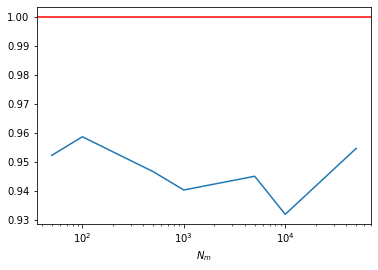

In [22]:
plt.plot(N_ms, ratio_Nm)
plt.axhline(y = 1., color = 'red')
plt.xlabel(r'$N_m$')
plt.xscale('log')
plt.savefig('./images/newimage01', bbox_inches = 'tight')
plt.show()

In [23]:
N_m = 50
rho_W = 1.; rho_u = 1.
Ms = [50, 100, 500, 1000, 5000, 10000, 50000]

ratio_M = []

for M in tqdm(Ms):
    
    se_sim, se_EHW, se_LZ, lamb = simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, verbose = False)
    ratio_M += [se_LZ/se_sim]

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:10:19<00:00, 602.85s/it]


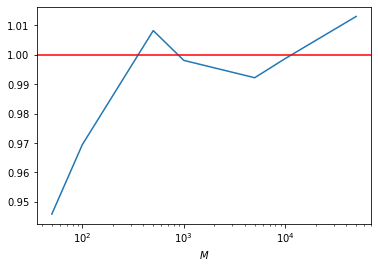

In [24]:
plt.plot(Ms, ratio_M)
plt.axhline(y = 1., color = 'red')
plt.xlabel(r'$M$')
plt.xscale('log')
plt.savefig('./images/newimage02', bbox_inches = 'tight')
plt.show()

# Random Coefficient Model

$$
Y_{mi} = \alpha + \beta_{mi} W_{mi} + u_{mi},
$$
where
$$
u_{mi} = \eta_m + \varepsilon_{mi}, \ \ W_{mi} = \zeta_m + \xi_{mi} \ \ \mathrm{ and } \ \ \beta_{mi} = \beta + \mu_m + \nu_{mi}.
$$

## $\rho_\beta = 0$

### Small M

#### $\rho_u = 0$ and $\rho_W = 0$

In [25]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:36<00:00,  7.57it/s]


(0.005325732020855824,
 0.005658302691230112,
 0.005492215711155363,
 1.9724917493635616)

#### $\rho_u = 0$ and $\rho_W = 0.5$

In [26]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:26<00:00,  7.77it/s]


(0.0052982301269633245,
 0.0056827200769315155,
 0.005479561779694547,
 1.861818604749033)

#### $\rho_u = 0$ and $\rho_W = 1$

In [27]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:29<00:00,  7.70it/s]


(0.005176541735680896,
 0.005698409190512,
 0.004874671461386308,
 0.651623917552003)

#### $\rho_u = 0.5$ and $\rho_W = 0$

In [28]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:27<00:00,  7.74it/s]


(0.005386503906043139,
 0.00565826090541844,
 0.005571141565401083,
 3.0680751047619097)

#### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [29]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:11<00:00,  8.08it/s]


(0.07002344298875848,
 0.005666062331916344,
 0.0672570780142181,
 1.0845542939206527)

#### $\rho_u = 0.5$ and $\rho_W = 1$

In [30]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:51<00:00,  7.30it/s]


(0.10492678016259359,
 0.00570685511168106,
 0.0977594144954089,
 1.1525278230874008)

#### $\rho_u = 1$ and $\rho_W = 0$

In [31]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:49<00:00,  7.33it/s]


(0.0052187907873767845,
 0.005640858480756412,
 0.00564255251870029,
 -239.79182266515835)

#### $\rho_u = 1$ and $\rho_W = 0.5$

In [32]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:53<00:00,  7.26it/s]


(0.10108030519398307,
 0.005644960682024484,
 0.09498841220628215,
 1.1328482440691916)

#### $\rho_u = 1$ and $\rho_W = 1$

In [33]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:57<00:00,  7.19it/s]


(0.14438680742343257,
 0.005680460986518644,
 0.1383392994157627,
 1.0894919746030678)

### Large M

#### $\rho_u = 0$ and $\rho_W = 0$

In [34]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:13<00:00,  6.93it/s]


(0.005260386383282918,
 0.005658978216273119,
 0.0056595499491169056,
 -672.5780132153183)

#### $\rho_u = 0$ and $\rho_W = 0.5$

In [35]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:04<00:00,  7.06it/s]


(0.005275320294399851,
 0.005644339175670543,
 0.005646335806125609,
 -178.74754510576946)

#### $\rho_u = 0$ and $\rho_W = 1$

In [36]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 1

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:05<00:00,  7.04it/s]


(0.005224653084490695,
 0.005655700490443792,
 0.005661516419077648,
 -71.25401420386105)

#### $\rho_u = 0.5$ and $\rho_W = 0$

In [37]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:07<00:00,  7.02it/s]


(0.005228577560817611,
 0.0056520386690037654,
 0.005656082241491023,
 -100.76537974144502)

#### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [38]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:07<00:00,  7.01it/s]


(0.008784098856820098,
 0.005643716087055895,
 0.009004357721173865,
 0.9204080874602015)

#### $\rho_u = 0.5$ and $\rho_W = 1$

In [39]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:10<00:00,  6.97it/s]


(0.011199362229108568,
 0.005647853952144483,
 0.01136383806062105,
 0.9618350880215274)

#### $\rho_u = 1$ and $\rho_W = 0$

In [40]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:05<00:00,  7.05it/s]


(0.005270976933683414,
 0.005655913069994233,
 0.005643908009050582,
 31.006255263421963)

#### $\rho_u = 1$ and $\rho_W = 0.5$

In [41]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:09<00:00,  6.99it/s]


(0.011436103376533986,
 0.0056609430157124625,
 0.011392997648811336,
 1.010066737002915)

#### $\rho_u = 1$ and $\rho_W = 1$

In [42]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:03<00:00,  7.09it/s]


(0.014747488072880295,
 0.005661395832459826,
 0.01509223088436965,
 0.9474411568581923)

## $\rho_\beta = 0.5$

### Small M

#### $\rho_u = 0$ and $\rho_W = 0$

In [43]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:10<00:00,  6.97it/s]


(0.0052838987106784896,
 0.005596911239344525,
 0.09746352670129908,
 -0.0003597271738227946)

#### $\rho_u = 0$ and $\rho_W = 0.5$

In [44]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:00<00:00,  7.13it/s]


(0.14355814449679957,
 0.005410447956491798,
 0.16095222870551348,
 0.795308082768642)

#### $\rho_u = 0$ and $\rho_W = 1$

In [45]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:02<00:00,  7.10it/s]


(0.24917442548723107,
 0.005547341242985676,
 0.2459443997925423,
 1.026452245187498)

#### $\rho_u = 0.5$ and $\rho_W = 0$

In [46]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:59<00:00,  7.16it/s]


(0.005110587037319631,
 0.005559692127065772,
 0.0963505307794772,
 -0.0005179215474223145)

#### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [47]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:09<00:00,  6.98it/s]


(0.2015781382290173,
 0.006056218682364446,
 0.21936813995962984,
 0.84426483251119)

#### $\rho_u = 0.5$ and $\rho_W = 1$

In [48]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:58<00:00,  7.16it/s]


(0.29060413601179674,
 0.005667851625381777,
 0.27788819196812575,
 1.0936512838707162)

#### $\rho_u = 1$ and $\rho_W = 0$

In [49]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:01<00:00,  7.11it/s]


(0.005469083938384975,
 0.005901230801707026,
 0.11000716249850975,
 -0.00040720536435426226)

#### $\rho_u = 1$ and $\rho_W = 0.5$

In [50]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:53<00:00,  7.25it/s]


(0.16269456958340256,
 0.005202983835425693,
 0.17442768296075323,
 0.8698762847104683)

#### $\rho_u = 1$ and $\rho_W = 1$

In [51]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:53<00:00,  7.26it/s]


(0.310613898347227,
 0.0057258789201520745,
 0.3019973878974347,
 1.05789835021845)

### Large M

#### $\rho_u = 0$ and $\rho_W = 0$

In [52]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:00<00:00,  7.14it/s]


(0.005368785860659189,
 0.0056831756430222894,
 0.01151422541713563,
 -0.03464959944241466)

#### $\rho_u = 0$ and $\rho_W = 0.5$

In [53]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:51<00:00,  7.29it/s]


(0.016521368849474468,
 0.005688488127794552,
 0.01954359595811991,
 0.6882190499240196)

#### $\rho_u = 0$ and $\rho_W = 1$

In [54]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:49<00:00,  7.32it/s]


(0.025354497639936836,
 0.005675948080319806,
 0.02693221347130796,
 0.880983594187087)

#### $\rho_u = 0.5$ and $\rho_W = 0$

In [55]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:47<00:00,  7.36it/s]


(0.005324419033983897,
 0.005684519453593874,
 0.011490815720732205,
 -0.03975251952238736)

#### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [56]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:00<00:00,  7.14it/s]


(0.018236197195495726,
 0.005698156881282647,
 0.020812157666009558,
 0.7489572899547116)

#### $\rho_u = 0.5$ and $\rho_W = 1$

In [57]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:46<00:00,  7.37it/s]


(0.026885079440661777,
 0.005668191541657279,
 0.0286217371534457,
 0.8775259194148946)

#### $\rho_u = 1$ and $\rho_W = 0$

In [58]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:53<00:00,  7.26it/s]


(0.005234333977619191,
 0.005639708398507389,
 0.011340052106308207,
 -0.04554227898167404)

#### $\rho_u = 1$ and $\rho_W = 0.5$

In [59]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:33<00:00,  7.62it/s]


(0.01907100884665055,
 0.005650330225949053,
 0.021727133510651454,
 0.7537955300692007)

#### $\rho_u = 1$ and $\rho_W = 1$

In [60]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:24<00:00,  9.25it/s]


(0.02891820837278462,
 0.005710297205924163,
 0.030735023352506607,
 0.8811679551138785)

## $\rho_\beta = 1$

### Small M

#### $\rho_u = 0$ and $\rho_W = 0$

In [61]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:05<00:00,  8.20it/s]


(0.005007084838392344,
 0.00541106089834781,
 0.13446516422490265,
 -0.00023314727104104172)

#### $\rho_u = 0$ and $\rho_W = 0.5$

In [62]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:21<00:00,  7.87it/s]


(0.23251843467486816,
 0.005801770499780702,
 0.26180631073462046,
 0.7886738029598606)

#### $\rho_u = 0$ and $\rho_W = 1$

In [63]:
N_m = 5000; M = 50
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:02<00:00,  8.27it/s]


(0.36779115139467133,
 0.00552411959906697,
 0.3613824449441551,
 1.035790577075603)

#### $\rho_u = 0.5$ and $\rho_W = 0$

In [64]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:20<00:00,  7.87it/s]


(0.004950407327596477,
 0.0053112376489069055,
 0.13177516026074515,
 -0.00021357922032968793)

#### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [65]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:47<00:00,  7.36it/s]


(0.23881574848057863,
 0.005642324885915299,
 0.2635538723355487,
 0.8210010758389165)

#### $\rho_u = 0.5$ and $\rho_W = 1$

In [66]:
N_m = 5000; M = 50
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:23<00:00,  7.82it/s]


(0.32870289624071236,
 0.004868023452753756,
 0.32790858857534005,
 1.0048516266295413)

#### $\rho_u = 1$ and $\rho_W = 0$

In [67]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:58<00:00,  7.17it/s]


(0.005080013331245313,
 0.005491503773112557,
 0.13717156449438392,
 -0.00023156103940599407)

#### $\rho_u = 1$ and $\rho_W = 0.5$

In [68]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:29<00:00,  7.70it/s]


(0.23149049747866063,
 0.005238821639459158,
 0.2537172418902918,
 0.8323942888260725)

#### $\rho_u = 1$ and $\rho_W = 1$

In [69]:
N_m = 5000; M = 50
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:23<00:00,  7.82it/s]


(0.4403668558822443,
 0.006144598501678928,
 0.434488726820588,
 1.0272461615185395)

### Large M

#### $\rho_u = 0$ and $\rho_W = 0$

In [70]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:25<00:00,  7.78it/s]


(0.005362604732080944,
 0.005611192882454148,
 0.014962144134494612,
 -0.01418001975861867)

#### $\rho_u = 0$ and $\rho_W = 0.5$

In [71]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:30<00:00,  7.69it/s]


(0.022585857998273794,
 0.005683871636444782,
 0.026925068411684655,
 0.6898326367024071)

#### $\rho_u = 0$ and $\rho_W = 1$

In [72]:
N_m = 50; M = 5000
rho_u = 0.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:26<00:00,  7.76it/s]


(0.03551128128607302,
 0.005613450097705385,
 0.03713869834486508,
 0.9122761060210737)

#### $\rho_u = 0.5$ and $\rho_W = 0$

In [73]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:51<00:00,  7.30it/s]


(0.005344432300866921,
 0.0056595204792059,
 0.015107136124271127,
 -0.01767225743242215)

#### $\rho_u = 0.5$ and $\rho_W = 0.5$

In [74]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:58<00:00,  8.37it/s]


(0.024038919607367572,
 0.005712106518729973,
 0.027976374408218287,
 0.7269408135928298)

#### $\rho_u = 0.5$ and $\rho_W = 1$

In [75]:
N_m = 50; M = 5000
rho_u = 0.5; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:29<00:00,  7.69it/s]


(0.03560010222380853,
 0.005650091560707229,
 0.03870402922937926,
 0.8426860329833817)

#### $\rho_u = 1$ and $\rho_W = 0$

In [76]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:16<00:00,  7.96it/s]


(0.0052586676969412875,
 0.005705700793954134,
 0.01524578099300228,
 -0.024522036342860574)

#### $\rho_u = 1$ and $\rho_W = 0.5$

In [77]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 0.5

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [06:18<00:00,  7.93it/s]


(0.025124816054981257,
 0.005683037902944131,
 0.02868124869539785,
 0.7578723233309002)

#### $\rho_u = 1$ and $\rho_W = 1$

In [78]:
N_m = 50; M = 5000
rho_u = 1.; rho_W = 1.

simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W, var_beta = 1., rho_beta = 1.)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:52<00:00,  8.52it/s]


(0.036893166411783404,
 0.005668115808451327,
 0.04007963124706603,
 0.8441980489512403)

## Sensitivity to $\rho_W$ and $\rho_u$

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [1:06:53<00:00, 364.89s/it]


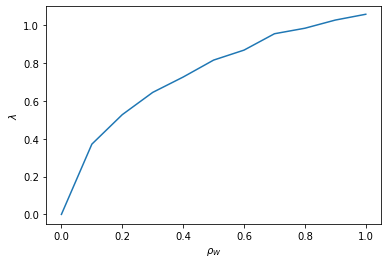

In [79]:
M = 50; N_m = 5000

rho_u = 1.0
rho_Ws = [round(0.1 * i, 1) for i in range(0, 11)]
rho_beta = 1.0

lambs = []

for rho_W in tqdm(rho_Ws):

    se_sim, se_EHW, se_LZ, lamb = simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W,
                                           var_beta = 1., rho_beta = rho_beta, verbose = False)
    lambs += [lamb]

plt.plot(rho_Ws, lambs)
plt.xlabel(r'$\rho_{W}$')
plt.ylabel(r'$\lambda$')
plt.ylim((-0.05, 1.10))
plt.savefig('./images/newimage03', bbox_inches = 'tight')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [1:03:44<00:00, 347.67s/it]


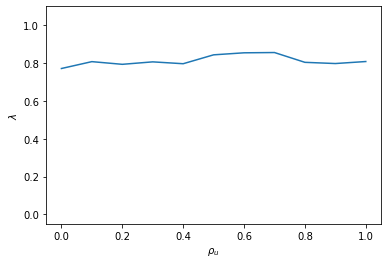

In [80]:
M = 50; N_m = 5000

rho_W = 0.5
rho_us = [round(0.1 * i, 1) for i in range(0, 11)]
rho_beta = 1.0

lambs = []

for rho_u in tqdm(rho_us):

    se_sim, se_EHW, se_LZ, lamb = simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W,
                                           var_beta = 1., rho_beta = rho_beta, verbose = False)
    lambs += [lamb]

plt.plot(rho_us, lambs)
plt.xlabel(r'$\rho_{u}$')
plt.ylabel(r'$\lambda$')
plt.ylim((-0.05, 1.10))
plt.savefig('./images/newimage04', bbox_inches = 'tight')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [54:55<00:00, 329.54s/it]


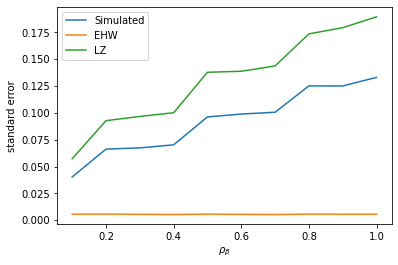

In [81]:
M = 50; N_m = 5000

rho_W = 0.2
rho_u = 0.
rho_betas = [round(0.1 * i, 1) for i in range(1, 11)]

se_sims = []; se_EHWs = []; se_LZs = []; lambs = []

for rho_beta in tqdm(rho_betas):

    se_sim, se_EHW, se_LZ, lamb = simulate(N_m = N_m, M = M, rho_u = rho_u, rho_W = rho_W,
                                           var_beta = 1., rho_beta = rho_beta, verbose = False)
    se_sims += [se_sim]
    se_EHWs += [se_EHW]
    se_LZs += [se_LZ]
    lambs += [lamb]

plt.plot(rho_betas, se_sims, label = 'Simulated')
plt.plot(rho_betas, se_EHWs, label = 'EHW')
plt.plot(rho_betas, se_LZs, label = 'LZ')
plt.xlabel(r'$\rho_{\beta}$')
plt.ylabel('standard error')
plt.legend()
plt.savefig('./images/newimage05', bbox_inches = 'tight')
plt.show()

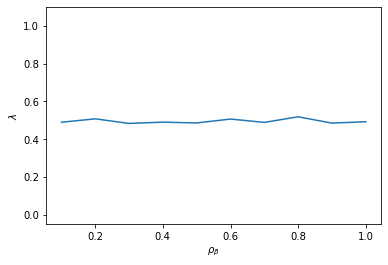

In [82]:
plt.plot(rho_betas, lambs)
plt.xlabel(r'$\rho_{\beta}$')
plt.ylabel(r'$\lambda$')
plt.ylim((-0.05, 1.10))
plt.savefig('./images/newimage06', bbox_inches = 'tight')
plt.show()

In [83]:
# import statsmodels.formula.api as smf

# N_m = 5000; M = 50
# mu_alpha = 1.; var_alpha = 0.; rho_alpha = 0.; mu_beta = 2.
# mu_W = 2.; var_W = 1.; var_u = 1.; var_beta = 1.

# rho_beta = 1.; rho_u = 1.; rho_W = 0.5

# alpha, beta = alpha_beta(N_m, M, mu_alpha, var_alpha, rho_alpha, mu_beta, var_beta, rho_beta)

# Y, W, X, C = generate(N_m, M, alpha, beta, mu_W, var_W, rho_W, var_u, rho_u)

# data = pd.DataFrame(np.concatenate([Y, X, C], axis = 1))
# data.columns = ['Y', 'const', 'W', 'C']

In [84]:
# mod = smf.mixedlm('Y ~ W', data, groups = data['C'], re_formula = '~W')
# mod = mod.fit(method = ['lbfgs'])
# mod.summary()

In [85]:
# mod2 = sm.OLS(Y, X).fit(cov_type = 'HC0')
# mod2.summary()